In [1]:
import pandas as pd
from glob import glob
import os
import seaborn as sns
import re
from matplotlib import pyplot as plt

In [2]:
fastqc_results = glob("01_data_qc/QualityControl/*_001_fastqc/fastqc_data.txt")

In [3]:
def get_fastqc_data(path):
    name, suffixes = os.path.basename(os.path.dirname(path)).split("_", maxsplit=1)
    if 'Swift-long' in name:
        ide, _, _, conc, repl = name.split("-")
        kit = "Swiftlong"
    else:
        ide, kit, conc, repl = name.split("-")
    read = int(re.search(r"_R([12])_", suffixes).group(1))
    row_const = {'kit': kit, 'conc': conc, 'repl': repl, 'read': read}
    section = 0
    rows = []
    with open(path) as f:
        for line in f:
            if section == 0:
                if line.startswith(">>Per base sequence content"):
                    section = 1
            elif section == 1:
                section += 1
            else:
                if line.startswith(">>END_MODULE"):
                    return rows
                else:
                    parts = line.strip().split()
                    if "-" in parts[0]:
                        start, end = [int(x) for x in parts[0].split("-")]
                    else:
                        start = end = int(parts[0])
                    for nucleotide, percent in zip("GATC", parts[1:]):
                        row = {"start": start, "end": end, "nucleotide": nucleotide, "percent": float(percent)}
                        row.update(row_const)
                        rows.append(row)
    return []
                
            

In [5]:
df = pd.DataFrame([k for ks in map(get_fastqc_data, fastqc_results) for k in ks])

In [6]:
df.head()

,start,end,nucleotide,percent,kit,conc,repl,read
0,1,1,G,26.443208,Kapa,100ng,4,2
1,1,1,A,21.347386,Kapa,100ng,4,2
2,1,1,T,22.167710,Kapa,100ng,4,2
3,1,1,C,30.041696,Kapa,100ng,4,2
4,2,2,G,20.699368,Kapa,100ng,4,2


## All kits combined

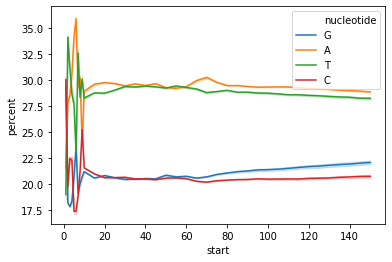

In [7]:
sns.lineplot(data=df, x='start', y='percent', hue='nucleotide')

## Read 1

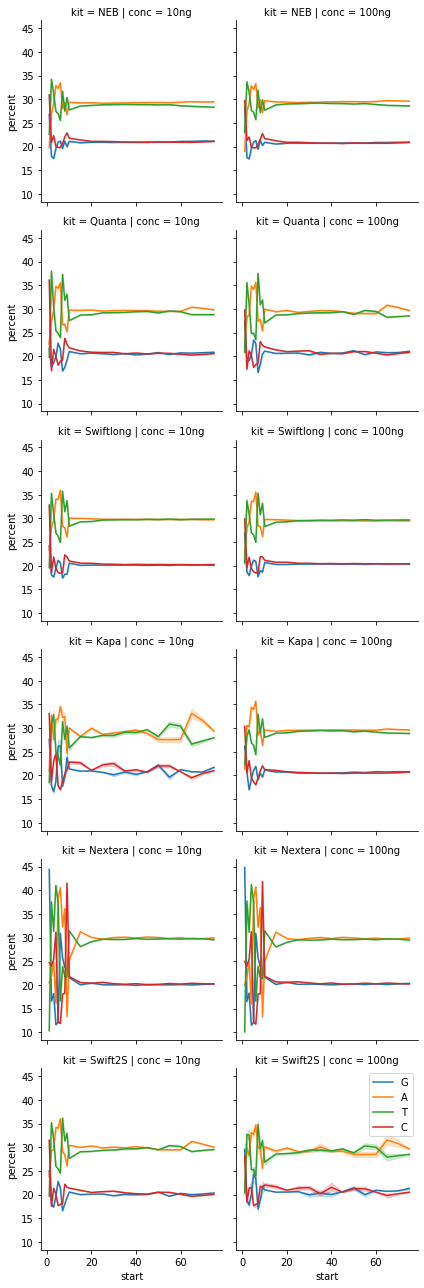

In [8]:
g = sns.FacetGrid(df[(df.start<80)&(df.read==1)], col="conc", row="kit", hue='nucleotide')
g.map(sns.lineplot, 'start', 'percent')
plt.legend()

## Read 2

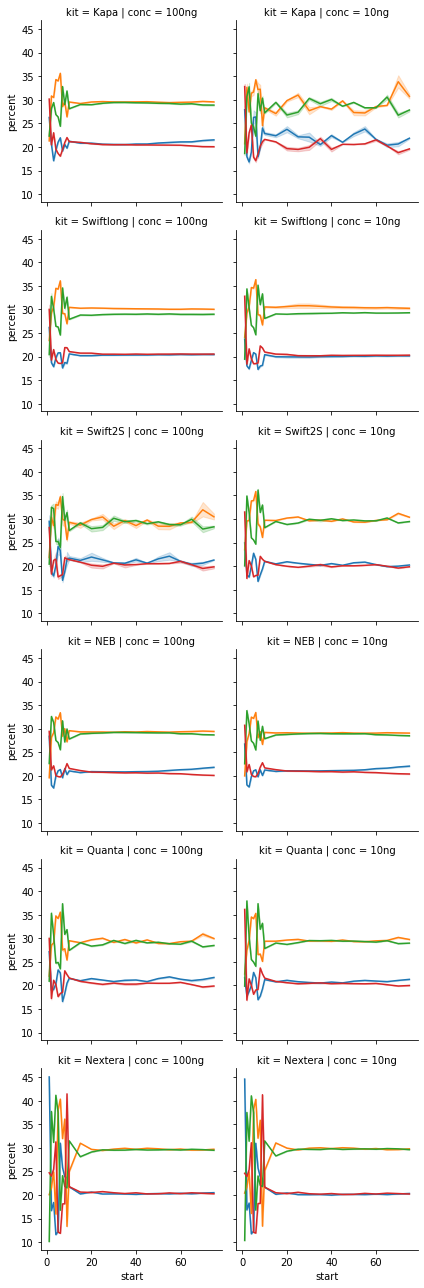

In [9]:
g = sns.FacetGrid(df[(df.start<80)&(df.read==2)], col="conc", row="kit", hue='nucleotide')
g.map(sns.lineplot, 'start', 'percent')